In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
!rm -rf data-bak && mv data data-bak && mkdir data
!cp ../Scrapers/data/fighter_info.csv data/
!cp ../Scrapers/data/event_data_sherdog.csv data/
!cp ../Scrapers/data/github/master.csv data/
!cp -R ../Scrapers/data/fighters data/

In [3]:
# Remove all fights before 2012

df = pd.read_csv('data/event_data_sherdog.csv')
df['event date'] = pd.to_datetime(df['event date'])
df = df[df['event date'] >= '2012-01-01']
df.to_csv('data/event_data_sherdog.csv', index=False)

In [4]:
# Remove all DQs, No Contests, and Draws

df = pd.read_csv('data/event_data_sherdog.csv')
print(f"Number of rows before filtering: {len(df)}")
df = df[~df['winning method'].str.contains('Disqualification|No contest|Draw', case=False)]
print(f"Number of rows after filtering: {len(df)}")
df.to_csv('data/event_data_sherdog.csv', index=False)

Number of rows before filtering: 5263
Number of rows after filtering: 5134


In [5]:
# Remove special characters from winning fighter column

df = pd.read_csv('data/event_data_sherdog.csv')
def clean_name(name):
    return re.sub(r'[^a-zA-Z\s]', '', name).strip()
df['winning fighter'] = df['winning fighter'].apply(clean_name)
df['fighter 1'] = df['fighter 1'].apply(clean_name)
df['fighter 2'] = df['fighter 2'].apply(clean_name)
df.to_csv('data/event_data_sherdog.csv', index=False)

In [6]:
# Randomly switch 50% of fighter 1 to fighter 2 to balance dataset

# df = pd.read_csv('data/event_data_sherdog.csv')

# # Create the target variable: 1 if Fighter 1 wins, else 0
# df['target'] = (df['winning fighter'] == df['fighter 1']).astype(int)

# # Randomly select half of the rows to swap
# rows_to_swap = df.sample(frac=0.5, random_state=42).index

# # Swap Fighter 1 and Fighter 2 stats in the selected rows
# df.loc[rows_to_swap, ['fighter1_age_on_fight_night', 'fighter2_age_on_fight_night']] = \
#     df.loc[rows_to_swap, ['fighter2_age_on_fight_night', 'fighter1_age_on_fight_night']].values

# df.loc[rows_to_swap, ['fighter 1', 'fighter 2']] = \
#     df.loc[rows_to_swap, ['fighter 2', 'fighter 1']].values

# df.loc[rows_to_swap, ['fighter1_current_win_streak', 'fighter2_current_win_streak']] = \
#     df.loc[rows_to_swap, ['fighter2_current_win_streak', 'fighter1_current_win_streak']].values

# df.loc[rows_to_swap, ['fighter1_recent_win_rate_7fights', 'fighter2_recent_win_rate_7fights']] = \
#     df.loc[rows_to_swap, ['fighter2_recent_win_rate_7fights', 'fighter1_recent_win_rate_7fights']].values

# df.loc[rows_to_swap, ['fighter1_recent_win_rate_5fights', 'fighter2_recent_win_rate_5fights']] = \
#     df.loc[rows_to_swap, ['fighter2_recent_win_rate_5fights', 'fighter1_recent_win_rate_5fights']].values

# df.loc[rows_to_swap, ['fighter1_recent_win_rate_3fights', 'fighter2_recent_win_rate_3fights']] = \
#     df.loc[rows_to_swap, ['fighter2_recent_win_rate_3fights', 'fighter1_recent_win_rate_3fights']].values

# df.loc[rows_to_swap, ['fighter1_current_layoff', 'fighter2_current_layoff']] = \
#     df.loc[rows_to_swap, ['fighter2_current_layoff', 'fighter1_current_layoff']].values

# df.loc[rows_to_swap, ['fighter1_total_wins', 'fighter2_total_wins']] = \
#     df.loc[rows_to_swap, ['fighter2_total_wins', 'fighter1_total_wins']].values

# df.loc[rows_to_swap, ['fighter1_total_losses', 'fighter2_total_losses']] = \
#     df.loc[rows_to_swap, ['fighter2_total_losses', 'fighter1_total_losses']].values

# # Swap the target variable
# df.loc[rows_to_swap, 'target'] = 1 - df.loc[rows_to_swap, 'target']

# df.to_csv('data/event_data_sherdog.csv', index=False)

df = pd.read_csv('data/event_data_sherdog.csv')

# Create the target variable: 1 if Fighter 1 wins, else 0
df['target'] = (df['winning fighter'] == df['fighter 1']).astype(int)

# Randomly select half of the rows to swap
rows_to_swap = df.sample(frac=0.5, random_state=42).index

# Swap Fighter 1 and Fighter 2 stats in the selected rows
swap_columns = [
    ('fighter1_age_on_fight_night', 'fighter2_age_on_fight_night'),
    ('fighter 1', 'fighter 2'),
    ('fighter1_current_win_streak', 'fighter2_current_win_streak'),
    ('fighter1_recent_win_rate_7fights', 'fighter2_recent_win_rate_7fights'),
    ('fighter1_recent_win_rate_5fights', 'fighter2_recent_win_rate_5fights'),
    ('fighter1_recent_win_rate_3fights', 'fighter2_recent_win_rate_3fights'),
    ('fighter1_current_layoff', 'fighter2_current_layoff'),
    ('fighter1_total_wins', 'fighter2_total_wins'),
    ('fighter1_total_losses', 'fighter2_total_losses'),
    ('fighter1_height_in_inches', 'fighter2_height_in_inches')
]

for col1, col2 in swap_columns:
    df.loc[rows_to_swap, [col1, col2]] = df.loc[rows_to_swap, [col2, col1]].values

# Swap the target variable
df.loc[rows_to_swap, 'target'] = 1 - df.loc[rows_to_swap, 'target']

# Save the updated dataset
df.to_csv('data/event_data_sherdog.csv', index=False)


In [ ]:
!open data/event_data_sherdog.csv

# Basic Linear Regression w/ Basic Dependent Variables
##### X: fighter1_age_on_fight_night, fighter2_age_on_fight_night
##### y: winning fighter (target)

In [ ]:
df = pd.read_csv('data/event_data_sherdog.csv')
df.head()

In [ ]:
# Analyze data

# Data distribution
plt.title('Age Distribution Plot')
sns.histplot(df['fighter1_age_on_fight_night'], kde=True)
plt.show()

In [ ]:
# Create the target variable: 1 if Fighter 1 wins, else 0

# df['target'] = (df['winning fighter'] == df['fighter 1']).astype(int)

In [ ]:
# Split the dataset into dependent/independent variables

X = df[['fighter1_age_on_fight_night', 'fighter2_age_on_fight_night']]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [ ]:
# Standardize features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Train the Logistic Regression model

model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
# Predict on the test set

y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n")
print(conf_matrix)
print("\nClassification Report:\n")
print(report)

### Accuracy
- **58.03%**: This is the overall accuracy of the model, meaning that about 58% of the time, the model correctly predicts the winner based on the ages of the fighters.

### Confusion Matrix
- **True Negatives (314)**: The number of times the model correctly predicted that Fighter 2 would win.
- **False Positives (199)**: The number of times the model predicted that Fighter 1 would win, but Fighter 2 actually won.
- **False Negatives (232)**: The number of times the model predicted that Fighter 2 would win, but Fighter 1 actually won.
- **True Positives (282)**: The number of times the model correctly predicted that Fighter 1 would win.

### Classification Report
- **Precision**: The percentage of true positive predictions out of all positive predictions.
  - Fighter 1: **59%**
  - Fighter 2: **58%**
- **Recall**: The percentage of true positive predictions out of all actual positives.
  - Fighter 1: **55%**
  - Fighter 2: **61%**
- **F1-Score**: The harmonic mean of precision and recall, providing a single metric to evaluate the model's performance.
  - Fighter 1: **57%**
  - Fighter 2: **59%**

### Interpretation
- The model has a moderate ability to predict the fight outcomes based solely on the fighters' ages. While the accuracy is slightly better than random guessing (50%), it's clear that age alone might not be a strong enough predictor for fight outcomes.
- The confusion matrix shows a reasonable balance between the two classes, indicating that the model is making predictions for both Fighter 1 and Fighter 2, although not with high precision or recall.

### Next Steps
To improve the model, you might consider:
1. **Incorporating Additional Features**: Include more predictors like win streaks, heights, reach, experience, etc., to see if they improve the model's performance.
2. **Feature Engineering**: Create new features that might capture more complex relationships between the fighters (e.g., age difference, win rate difference).
3. **Advanced Models**: Experiment with more complex models, such as Random Forests, SVMs, or Neural Networks, to capture nonlinear relationships in the data.

In [ ]:
# Decision Tree w/ Same Features

# Train the Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Decision Tree")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


In [ ]:
# Random Forest w/ Same Features

# Train the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Random Forest")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

In [ ]:
# Support Vector Machine w/ Same Features

# Train the SVM model
model = SVC()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Support Vector Machine (SVM)")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

In [ ]:
# XGBoost w/ Same Features

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=0)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Print the results
print("XGBoost Model Results:")
print("Accuracy: {:.2f}%".format(xgb_accuracy * 100))
print("\nConfusion Matrix:\n", xgb_conf_matrix)
print("\nClassification Report:\n", xgb_report)

In [ ]:
# LightGBM w/ Same Features

# Initialize LightGBM model
lgbm_model = LGBMClassifier(random_state=0)

# Train the LightGBM model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_report = classification_report(y_test, y_pred_lgbm)
lgbm_conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

# Print the results
print("LightGBM Model Results:")
print("Accuracy: {:.2f}%".format(lgbm_accuracy * 100))
print("\nConfusion Matrix:\n", lgbm_conf_matrix)
print("\nClassification Report:\n", lgbm_report)

---

# Adding Features

##### X: 
- fighter1_age_on_fight_night
- fighter2_age_on_fight_night
- fighter1_height_in_inches
- fighter2_height_in_inches
- fighter1_current_win_streak
- fighter2_current_win_streak
##### y: winning fighter (target)

Accuracy: 63.68%

Confusion Matrix:

[[331 183]
 [190 323]]

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       514
           1       0.64      0.63      0.63       513

    accuracy                           0.64      1027
   macro avg       0.64      0.64      0.64      1027
weighted avg       0.64      0.64      0.64      1027

Coefficients:
fighter2_current_win_streak   -0.747037
fighter1_age_on_fight_night   -0.160776
fighter1_height_in_inches     -0.022062
fighter2_height_in_inches      0.016900
fighter2_age_on_fight_night    0.152205
fighter1_current_win_streak    0.699473
dtype: float64


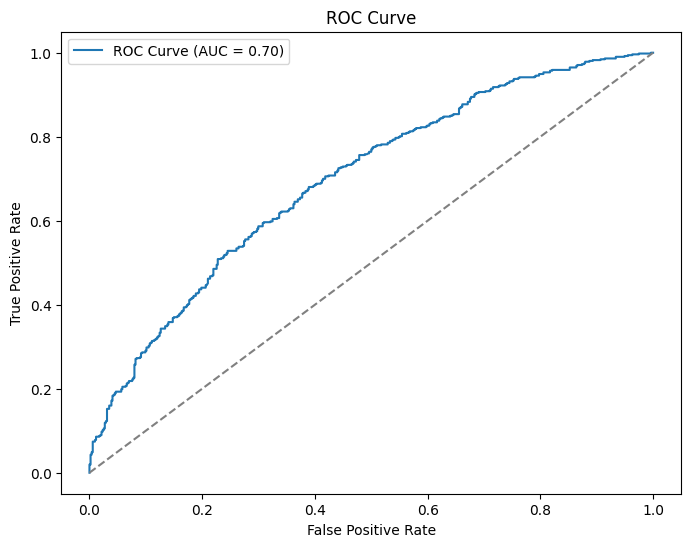

In [11]:
# Logistic Regression

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n")
print(conf_matrix)
print("\nClassification Report:\n")
print(report)

# Get the coefficients of the logistic regression model
coefficients = pd.Series(model.coef_[0], index=features)
coefficients = coefficients.sort_values()
print("Coefficients:")
print(coefficients)

# Get the predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [12]:
# Random Forest

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Random Forest model
model = RandomForestClassifier(random_state=0)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Random Forest Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Random Forest Model Results:
Accuracy: 60.56%

Confusion Matrix:
 [[315 199]
 [206 307]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.61      0.61       514
           1       0.61      0.60      0.60       513

    accuracy                           0.61      1027
   macro avg       0.61      0.61      0.61      1027
weighted avg       0.61      0.61      0.61      1027



In [13]:
# Decision Tree

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Decision Tree model
model = DecisionTreeClassifier(random_state=0)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Decision Tree Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Decision Tree Model Results:
Accuracy: 55.70%

Confusion Matrix:
 [[293 221]
 [234 279]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.57      0.56       514
           1       0.56      0.54      0.55       513

    accuracy                           0.56      1027
   macro avg       0.56      0.56      0.56      1027
weighted avg       0.56      0.56      0.56      1027



In [14]:
# XGBoost

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize XGBoost model
model = XGBClassifier(random_state=0)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("XGBoost Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

XGBoost Model Results:
Accuracy: 59.10%

Confusion Matrix:
 [[297 217]
 [203 310]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.58      0.59       514
           1       0.59      0.60      0.60       513

    accuracy                           0.59      1027
   macro avg       0.59      0.59      0.59      1027
weighted avg       0.59      0.59      0.59      1027



# Trying with single 'age_difference' instead of seperate fighter1 and fighter2

In [ ]:
# Logistic Regression

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Calculate age difference
df['age_difference'] = df['fighter1_age_on_fight_night'] - df['fighter2_age_on_fight_night']

# Select features to include in the model, replacing the two age features with age_difference
features = [
    'age_difference',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak',
    'fighter1_current_layoff',
    'fighter2_current_layoff'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
coefficients = pd.Series(model.coef_[0], index=features)
coefficients = coefficients.sort_values()
intercept = model.intercept_
r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%\n".format(accuracy * 100))
print("Coefficients:")
print(coefficients, "\n")
print(f'Intercept: {intercept}\n')
print(f'R-squared (Training Set): {r_squared_train}')
print(f'R-squared (Test Set): {r_squared_test}')
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Get the predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
